In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import mean_absolute_error


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

## Project: Forecasting "chocolate" keyword search with Prophet
--------
Using Google Trends publicly available service, we will try to predict next 12 months search for the keyword search "chocolate" in the USA. Upto date data can be obtained via the following [link](https://trends.google.com/trends/explore?date=all&geo=US&q=chocolate).


### 1. Explore and prepare Data 
-------

In [6]:
df = pd.read_csv('chocolate_trends.csv', header = 1) # first row as header 

df.head()

,Month,chocolate: (United States)
0,2004-01,36
1,2004-02,46
2,2004-03,28
3,2004-04,31
4,2004-05,31


In [7]:
from pandas.tseries.offsets import MonthEnd

df['Month'] = pd.to_datetime(df['Month']) + MonthEnd(1)

df.columns = ['month', 'choco_US']

In [8]:
df = df.set_index('month')

In [9]:
df.head()

,choco_US
month,
2004-01-31,36
2004-02-29,46
2004-03-31,28
2004-04-30,31
2004-05-31,31


In [10]:
df.tail()

,choco_US
month,
2024-02-29,66
2024-03-31,58
2024-04-30,52
2024-05-31,55
2024-06-30,52


In [11]:
df.shape[0]/12 # approximately 20 years of data

20.5

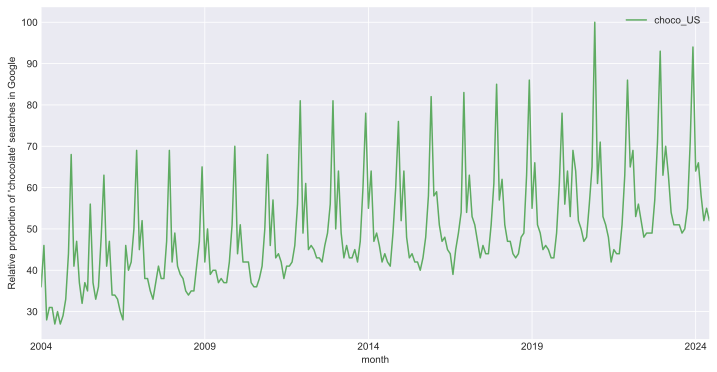

In [12]:
fig, axes = plt.subplots(figsize = (12,6))

df.plot(ax = axes, color= 'green', alpha = 0.6)

axes.set_ylabel("Relative proportion of 'chocolate' searches in Google")
axes.grid()

We can observe seasonality with strong peaks towards the end of each year, around december which may not be surprising as it corresponds to christmas time. We also have an overall increasing trend over the years. 

Note that the data describes the popularity of the keyword 'chocolate' in Google searches in the USA from Jan 2004 to until present time. The values are expressed as a proportion relative to the period where the search term was the most popular, which occurs in December 2021 and has a value of 100. Therefore, a value of 50 for a particular month means that the keyword “chocolate” was searched for half as often, relative to the month of December 2021.

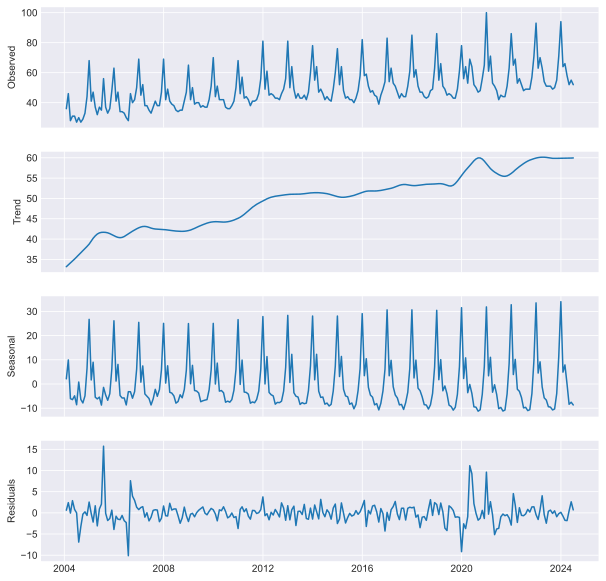

In [13]:
# STL decomposition to see trend and seasonality more clearly

decomp = STL(df['choco_US'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()

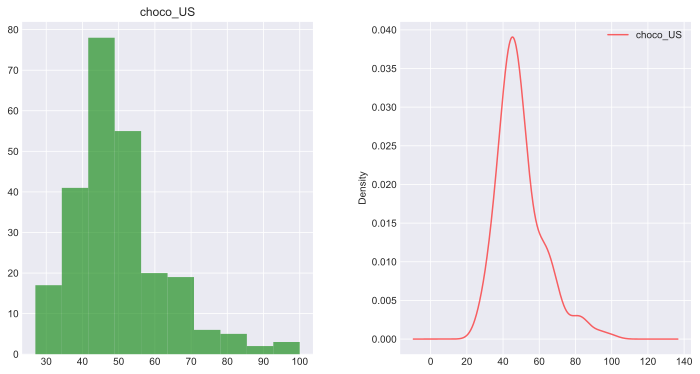

In [14]:
fig, axes = plt.subplots(1,2, figsize = (12,6))

df.hist(ax = axes[0], color= 'green', alpha = 0.6)
df.plot(kind = 'kde', ax = axes[1], color= 'red', alpha = 0.6)

axes[1].grid()

The distribution is fairly peaked, however slighltly left skewed. We may benefit from a box-cox type transform. 

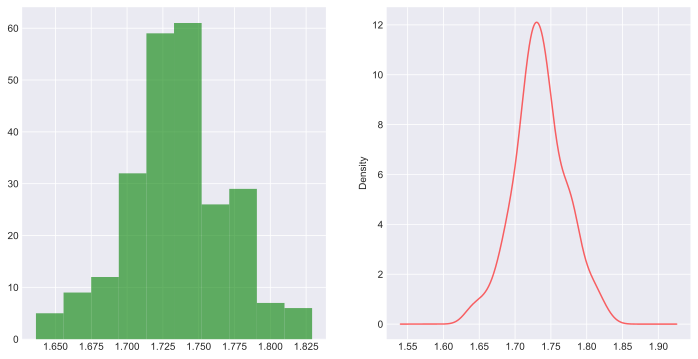

In [15]:
fitted_vals, lamb = boxcox(df['choco_US'])

df['tchoco_US'] = fitted_vals

fig, axes = plt.subplots(1,2, figsize = (12,6))

df['tchoco_US'].hist(ax = axes[0], color= 'green', alpha = 0.6)
df['tchoco_US'].plot(kind = 'kde', ax = axes[1], color= 'red', alpha = 0.6)

axes[1].grid()

The distribution now resembles more a Gaussian. For a Prophet like model where the regressor is time, this might not be very useful and usually box-cox transformation is helpful for linear models like SARIMA which likes Gaussian distributed targets. We are experimenting here!

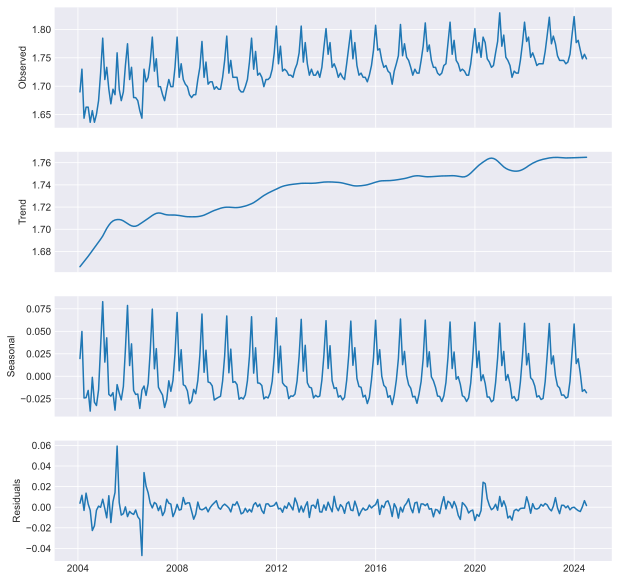

In [16]:
# STL decomposition of the transformed data to see trend and seasonality more clearly

decomp = STL(df['tchoco_US'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()

Observe that trend is smoothed and the slight variance in the seasonality component is reduced with respect to the raw data.

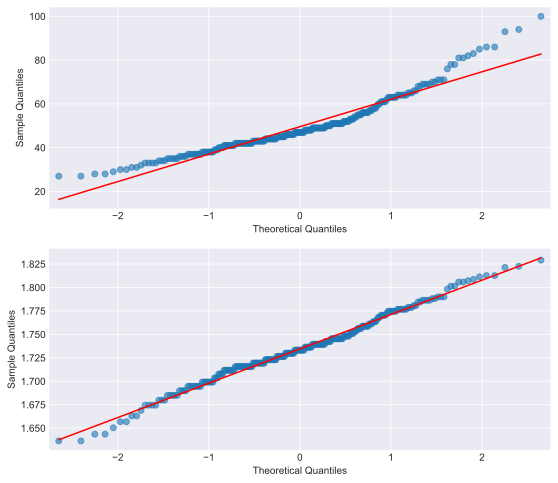

In [17]:
# qq plot of the original data vs box-cox transformed data

fig, axes = plt.subplots(2,1,figsize = (9,8))

qqplot(df['choco_US'], ax = axes[0], alpha = 0.6, line='r');
qqplot(df['tchoco_US'], ax = axes[1], alpha = 0.6, line='r');


axes[0].grid()
axes[1].grid()

Lets work with both raw data and the transformed one, we save them seperately and reserve the last 12 months as the test set. 

In [18]:
# remove the index and rename the columns as 'ds' and 'y' for both data sets 

dfp = pd.DataFrame()
dfpt = pd.DataFrame()

dfp['ds'] = df.index
dfpt['ds'] = df.index

dfp['y'] = df['choco_US'].values
dfpt['y'] = df['tchoco_US'].values

In [19]:
# train test split 
Ntest = 12

train, test = dfp[:-Ntest], dfp[-Ntest:]

ttrain, ttest = dfpt[:-Ntest], dfpt[-Ntest:]

### Apply Prophet and get the hyperparameters through Cross Validation (Walk forward validation)
-------

Prophet comes with many parameters that can be fine-tuned by more advanced users in order to produce better forecasts. Four parameters are usually tuned: `changepoint_prior_scale`, `seasonality_prior_scale`, `holidays_prior_scale`, and `seasonality_mode`:

- `changepoint_prior_scale`: The `changepoint_prior_scale` parameter is said to be the most impactful parameter in Prophet. It determines the flexibility of the trend, and particularly how much the trend changes at the trend change points. If the parameter is too small, the trend will underfit, and the variance observed in the data will be treated as noise. If it is set too high, the trend will overfit to noisy fluctuations. Using the range `[0.001, 0.01, 0.1, 0.5]` is enough to have a well-fitted model.

- `seasonality_prior_scale`: The `seasonality_prior_scale` parameter sets the flexibility of the seasonality. A large value allows the seasonal component to fit smaller fluctuations, while a small value will result in a smoother seasonal component. Using the range `[0.01, 0.1, 1.0, 10.0]` generally works well to find a good model.

- `holidays_prior_scale`: The holidays_prior_scale parameter sets the flexibility of the holiday effects and works just like `seasonality_prior_scale`. It can be tuned using the same range, `[0.01, 0.1, 1.0, 10.0]`.

- `seasonality_mode`: The seasonality_mode parameter can be either `additive` or `multiplicative`. By default, it is additive, but it can be set to multiplicative if you see that the seasonal fluctuation gets larger over time. This can be observed by plotting the time series, but when in doubt, you can include it in the hyper-parameter tuning process.

We’ll now move on to the next step, where we’ll combine hyperparameter tuning and cross-validation to find the optimal parameter combination for our model.

In [20]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'], 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
              'seasonality_prior_scale': [0.01, 0.1, 1., 10.]} # 'holidays_prior_scale': [0.01, 0.1, 1., 10.] can be added

In [21]:
from itertools import product

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]


In [ ]:
params[0]

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01}

Now, because we are working with monthly data, we must define our own cutoff dates. Recall that the cutoff dates define the training and testing periods during cross-validation. 

Here we’ll set the initial training period to be the first 5 years of data. Therefore, our first cutoff date will be `2009-01-31`. The last cutoff date can be set as the 12 months prior to the last row of the training set `2022-06-30`, and we’ll separate each cutoff date by 12 months, so that we have a model that forecasts a full year.

In [24]:
train.tail(13)

,ds,y
221,2022-06-30,48
222,2022-07-31,49
223,2022-08-31,49
224,2022-09-30,49
225,2022-10-31,57
226,2022-11-30,71
227,2022-12-31,93
228,2023-01-31,63
229,2023-02-28,70
230,2023-03-31,63


In [25]:
ttrain.head()

,ds,y
0,2004-01-31,1.689908
1,2004-02-29,1.729919
2,2004-03-31,1.643588
3,2004-04-30,1.663036
4,2004-05-31,1.663036


In [26]:
cutoffs = pd.date_range(start='2009-01-31', end='2022-06-30', freq='12M')

In [27]:
# evaluation metric to decide best parameter combination 

mse_vals = []

for param in params:

    m = Prophet(**param)

    m.add_country_holidays(country_name = 'US')

    m.fit(train)

    df_cv = cross_validation(model = m, horizon = '365 days', cutoffs = cutoffs, parallel='processes') # parallelize across cores
    df_p = performance_metrics(df_cv, rolling_window = 1) # rolling_window = 1 to average the metrics over the walk forward steps 

    mse_vals.append(df_p['mse'].values[0])

hptune_res = pd.DataFrame(params)

hptune_res['mse'] = mse_vals


12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:59 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing
12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
12:24:02 - 

In [28]:
# best model has multiplicative seasonality, changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.1

hptune_res.sort_values('mse')

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,mse
21,multiplicative,0.010,0.10,15.112147
22,multiplicative,0.010,1.00,15.686564
23,multiplicative,0.010,10.00,16.003004
5,additive,0.010,0.10,16.024262
25,multiplicative,0.100,0.10,16.265360
6,additive,0.010,1.00,16.690889
7,additive,0.010,10.00,16.789141
26,multiplicative,0.100,1.00,16.969187
27,multiplicative,0.100,10.00,17.166334
9,additive,0.100,0.10,17.264775


In [29]:
best_params = params[hptune_res.sort_values('mse').index[0]]

print(f"Best performing model has the following hyper-parameters:\n{best_params}")

Best performing model has the following hyper-parameters:
{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


In [30]:
# lets repeat the process with box-cox transformed data


tmse_vals = []

for param in params:

    m = Prophet(**param)

    m.add_country_holidays(country_name = 'US')

    m.fit(ttrain)

    df_cv = cross_validation(model = m, horizon = '365 days', cutoffs = cutoffs, parallel='processes') # parallelize across cores
    df_p = performance_metrics(df_cv, rolling_window = 1) # rolling_window = 1 to average the metrics over the walk forward steps 

    tmse_vals.append(df_p['mse'].values[0])

thptune_res = pd.DataFrame(params)

thptune_res['mse'] = tmse_vals

12:26:48 - cmdstanpy - INFO - Chain [1] start processing
12:26:48 - cmdstanpy - INFO - Chain [1] done processing
12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] done processing
12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing
12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing
12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing
12:26:51 - cmdstanpy - INFO - Chain [1

In [31]:
# best model has additive seasonality, changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.01
# this is not surprising as by box-cox transform we rendered the variance in the seasonality constant 
# this also caused a reduction in the seasonality_prior_scale

thptune_res.sort_values('mse')

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,mse
4,additive,0.010,0.01,0.000117
20,multiplicative,0.010,0.01,0.000118
5,additive,0.010,0.10,0.000125
7,additive,0.010,10.00,0.000128
21,multiplicative,0.010,0.10,0.000128
6,additive,0.010,1.00,0.000130
23,multiplicative,0.010,10.00,0.000131
22,multiplicative,0.010,1.00,0.000132
8,additive,0.100,0.01,0.000141
0,additive,0.001,0.01,0.000142


In [32]:
tbest_params = params[thptune_res.sort_values('mse').index[0]]

print(f"Best performing model on the transformed data has the following hyper-parameters:\n{tbest_params}")

Best performing model on the transformed data has the following hyper-parameters:
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


Since we have the best models for both approaches we undertake, we can fit them into the entire training set and evaluate them on the test set.

In [33]:
# un-transformed model 

m = Prophet(**best_params)

m.add_country_holidays(country_name = 'US')
m.fit(train)

12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future_df = m.make_future_dataframe(periods = 12, freq = 'M') # generates a df with all in sample and out of sample values 

forecast = m.predict(future_df)

In [35]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2004-01-31,38.115800,34.737098,44.730228,38.115800,38.115800,0.0,0.0,0.0,0.0,...,0.035046,0.035046,0.035046,0.035046,0.035046,0.035046,0.0,0.0,0.0,39.451605
1,2004-02-29,38.204655,41.372436,50.850498,38.204655,38.204655,0.0,0.0,0.0,0.0,...,0.199801,0.199801,0.199801,0.199801,0.199801,0.199801,0.0,0.0,0.0,45.837991
2,2004-03-31,38.299639,31.246599,40.804375,38.299639,38.299639,0.0,0.0,0.0,0.0,...,-0.058682,-0.058682,-0.058682,-0.058682,-0.058682,-0.058682,0.0,0.0,0.0,36.052157
3,2004-04-30,38.391558,30.628703,39.954245,38.391558,38.391558,0.0,0.0,0.0,0.0,...,-0.074516,-0.074516,-0.074516,-0.074516,-0.074516,-0.074516,0.0,0.0,0.0,35.530792
4,2004-05-31,38.486541,29.370488,39.023102,38.486541,38.486541,0.0,0.0,0.0,0.0,...,-0.117034,-0.117034,-0.117034,-0.100518,-0.100518,-0.100518,0.0,0.0,0.0,33.982319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2024-02-29,60.583698,67.930152,77.614895,60.583693,60.583703,0.0,0.0,0.0,0.0,...,0.199801,0.199801,0.199801,0.199801,0.199801,0.199801,0.0,0.0,0.0,72.688393
242,2024-03-31,60.678656,52.536201,62.014209,60.678651,60.678663,0.0,0.0,0.0,0.0,...,-0.058682,-0.058682,-0.058682,-0.058682,-0.058682,-0.058682,0.0,0.0,0.0,57.117940
243,2024-04-30,60.770552,51.556065,60.748591,60.770545,60.770560,0.0,0.0,0.0,0.0,...,-0.074516,-0.074516,-0.074516,-0.074516,-0.074516,-0.074516,0.0,0.0,0.0,56.242204
244,2024-05-31,60.865511,49.940665,59.029683,60.865502,60.865520,0.0,0.0,0.0,0.0,...,-0.100518,-0.100518,-0.100518,-0.100518,-0.100518,-0.100518,0.0,0.0,0.0,54.747443


In [36]:
# add the predictions yhat and upper/lower limits to the test set 

test.loc[test.index, ['yhat', 'yhat_lower', 'yhat_upper']] = forecast.loc[test.index, ['yhat', 'yhat_lower', 'yhat_upper']].values

test.head()


,ds,y,yhat,yhat_lower,yhat_upper
234,2023-07-31,51,51.088251,46.187374,55.826176
235,2023-08-31,49,50.056492,45.378562,54.785455
236,2023-09-30,50,50.587315,45.765874,55.256839
237,2023-10-31,55,56.563507,51.808593,61.080305
238,2023-11-30,71,69.026522,64.469414,73.782596


In [37]:
# Set a baseline as the last 12 months of the training set as the predictions 

test.loc[test.index, 'naive_seasonal'] = train.loc[train[-12:].index, ['y']].values
test.head()

/var/folders/q0/lz7h2q596yx70_f664l6gv8h0000gn/T/ipykernel_75305/274871414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test.index, 'naive_seasonal'] = train.loc[train[-12:].index, ['y']].values


,ds,y,yhat,yhat_lower,yhat_upper,naive_seasonal
234,2023-07-31,51,51.088251,46.187374,55.826176,49.0
235,2023-08-31,49,50.056492,45.378562,54.785455,49.0
236,2023-09-30,50,50.587315,45.765874,55.256839,49.0
237,2023-10-31,55,56.563507,51.808593,61.080305,57.0
238,2023-11-30,71,69.026522,64.469414,73.782596,71.0


In [38]:
# we evaluate the performance of the Prophet using MAE with respect to the baseline 

p_mae = mean_absolute_error(test['y'], test['yhat'])
b_mae = mean_absolute_error(test['y'], test['naive_seasonal'])

print(f"Test MAE Prophet vs Naive Seasonal Forecast: {p_mae:.3f} vs {b_mae:.3f}")

Test MAE Prophet vs Naive Seasonal Forecast: 1.788 vs 1.917


In [39]:
# Repeat the same process with the model suitable for the transformed data 

mt = Prophet(**tbest_params)

mt.add_country_holidays(country_name = 'US')
mt.fit(ttrain)

future_dft = mt.make_future_dataframe(periods = 12, freq = 'M') # generates a df with all in sample and out of sample values 

tforecast = mt.predict(future_dft)

tforecast.head()

12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-31,1.688579,1.682642,1.713152,1.688579,1.688579,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.008878,0.008878,0.008878,0.0,0.0,0.0,1.697457
1,2004-02-29,1.689042,1.705274,1.734276,1.689042,1.689042,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.030296,0.030296,0.030296,0.0,0.0,0.0,1.719339
2,2004-03-31,1.689538,1.666443,1.695251,1.689538,1.689538,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.008189,-0.008189,-0.008189,0.0,0.0,0.0,1.681349
3,2004-04-30,1.690018,1.664119,1.695214,1.690018,1.690018,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.009398,-0.009398,-0.009398,0.0,0.0,0.0,1.680620
4,2004-05-31,1.690514,1.658023,1.686761,1.690514,1.690514,0.0,0.0,0.0,0.0,...,-0.007539,-0.007539,-0.007539,-0.010275,-0.010275,-0.010275,0.0,0.0,0.0,1.672699


In [40]:
# add the predictions yhat and upper/lower limits to the test set 

ttest.loc[ttest.index, ['yhat', 'yhat_lower', 'yhat_upper']] = tforecast.loc[ttest.index, ['yhat', 'yhat_lower', 'yhat_upper']].values

ttest.head()

,ds,y,yhat,yhat_lower,yhat_upper
234,2023-07-31,1.745378,1.740751,1.726171,1.755734
235,2023-08-31,1.739477,1.741554,1.727499,1.756230
236,2023-09-30,1.742472,1.741084,1.727311,1.755546
237,2023-10-31,1.756207,1.756791,1.741890,1.771635
238,2023-11-30,1.789998,1.787042,1.772562,1.801692


In [41]:
def inverse_boxcox(y, lambda_val):
    if lambda_val == 0:
        return np.exp(y)
    else:
        return (y * lambda_val + 1) ** (1 / lambda_val)

cols_to_xform = ttest.columns[1:]

for col in cols_to_xform:

    ttest[col] = inverse_boxcox(ttest[col], lamb)


/var/folders/q0/lz7h2q596yx70_f664l6gv8h0000gn/T/ipykernel_75305/2491953858.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest[col] = inverse_boxcox(ttest[col], lamb)


In [42]:
# Set a baseline as the last 12 months of the training set as the predictions 

ttest.loc[ttest.index, 'naive_seasonal'] = train.loc[train[-12:].index, ['y']].values
ttest.head()

/var/folders/q0/lz7h2q596yx70_f664l6gv8h0000gn/T/ipykernel_75305/4235409541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest.loc[ttest.index, 'naive_seasonal'] = train.loc[train[-12:].index, ['y']].values


,ds,y,yhat,yhat_lower,yhat_upper,naive_seasonal
234,2023-07-31,51.0,49.421870,44.898017,54.815847,49.0
235,2023-08-31,49.0,49.690533,45.283875,55.008999,49.0
236,2023-09-30,50.0,49.532833,45.228957,54.742830,49.0
237,2023-10-31,55.0,55.229146,49.803611,61.557850,57.0
238,2023-11-30,71.0,69.339758,61.988313,78.181891,71.0


In [43]:
# we evaluate the performance of the Prophet using MAE with respect to the baseline 

tp_mae = mean_absolute_error(ttest['y'], ttest['yhat'])
tb_mae = mean_absolute_error(ttest['y'], ttest['naive_seasonal'])

print(f"Test MAE Prophet (on transformed data) vs Naive Seasonal Forecast: {tp_mae:.3f} vs {tb_mae:.3f}")

Test MAE Prophet (on transformed data) vs Naive Seasonal Forecast: 2.377 vs 1.917


The second method lead to larger MAE, so we can stick with the original!

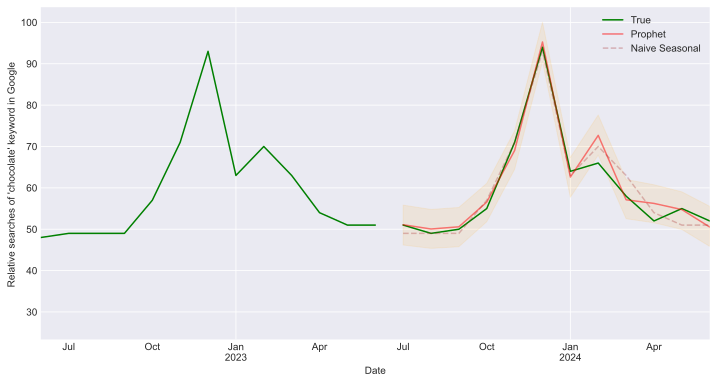

In [44]:
# Visualize the forecasts

train.index = train['ds']
test.index= test['ds']

fig, axes = plt.subplots(figsize = (12,6))

train['y'].plot(ax = axes, color = 'green', label = '')
test['y'].plot(ax = axes, color = 'green', label = 'True')
test['yhat'].plot(ax = axes, color = 'red', alpha = 0.5, label = 'Prophet')

test['naive_seasonal'].plot(ax = axes, color = 'brown', ls = '--', alpha = 0.3, label = 'Naive Seasonal')


axes.fill_between(x = test.index, y1 = test['yhat_lower'], y2 = test['yhat_upper'], color = 'orange', alpha = 0.1)


axes.set_xlim(train.index[-13],'2024-06-30')
axes.set_xlabel('Date')
axes.set_ylabel("Relative searches of 'chocolate' keyword in Google ")
axes.legend()

axes.grid()



Surprisingly, naive seasonal forecast does really well on the test set however Prophet beats this performance as we showed earlier by some small margin.

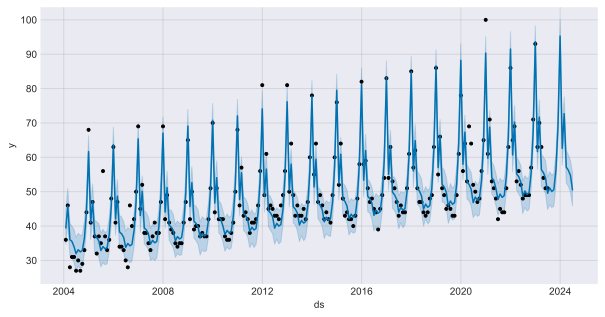

In [45]:
# Plotting in sample predictions with forecasts

fig, axes = plt.subplots(figsize = (10,5))

m.plot(forecast, ax = axes);


### Can we do better with SARIMA?
-----

Let's have a look if we can improve on Prophet using SARIMA

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

We first want to determine $d$ and $D$, namely overall trend and seasonal differencing we need to implement to render the data stationary. Recall that SARIMA models work best with stationary data. Of course we can automatically determine all the model parameters $p,d,q,P,D,Q$ using `auto_arima()` method from the pmd arima library which automatically choses the best model accounding to `AIC` criterion.  

#### Augmented Dicky-Fuller, ACF and PACF
------

In [47]:
# Helper function to decide if the series is stationary or not!

def adf(x): # Note that the null hypothesis is that the TS is non-stationary

    test, p_val, *_ = adfuller(x.dropna())

    print(f"ADF test statistic: {test:.5f}")
    print(f"ADF p-value: {p_val:.5f}")

    if p_val < 0.05:
        print('Time-series is stationary!')
    else:
        print('Time-series is not stationary!')

In [49]:
# we work with boxcox transformed data 

adf(dfpt['y'])

ADF test statistic: -2.23934
ADF p-value: 0.19228
Time-series is not stationary!


In [50]:
# Check first differencing with previous vals, first differencing in the boxcox transormed data has made the series stationary!

diff_y = dfpt['y'].diff(1)

adf(diff_y)

ADF test statistic: -9.18158
ADF p-value: 0.00000
Time-series is stationary!


We see that first differencing will already rendered the series stationary. We might expect this because we already flattened large seasonal fluctuations by box-cox transform which in turn removed the variance in the seasonal component of the series. Therefore we choose to work with a $d = 1$, $D = 0$

#### SARIMA model Selection
------
Now we have determined possible choices of $d$ and $D$, we can move on to the optimizing $p,q$ and $P,Q$. For this purpose we will use a helper function that will make a grid search of possible $p,q,P,Q$ values and sort the associated SARIMA models according to their `AIC`

In [51]:
p_vals = range(0,4,1)
q_vals = range(0,4,1)
P_vals = range(0,4,1)
Q_vals = range(0,4,1)

order_list = list(product(p_vals,q_vals,P_vals,Q_vals)) # all possible tuples of (p,q,P,Q) within the specified range 

In [55]:
def auto_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = list()

    for order in tqdm(order_list):

        try:

            model= SARIMAX(endog, exog, order = (order[0], d, order[1]), seasonal_order=(order[2],D,order[3],s), simple_differencing=False)
            model_fit = model.fit(disp = False)

        except:
            continue

        aic = model_fit.aic
        results.append([order, aic])

    res_df = pd.DataFrame(results)
    res_df.columns = ['(p,q,P,Q)', 'AIC']

    # Sort in ascending order of AIC

    res_df = res_df.sort_values(by = 'AIC', ascending=True).reset_index(drop = True)

    return res_df

In [58]:
# to suppress convergence warnings 

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# check the best Model with d = 1 and s = 12 

d = 1
s = 12

auto_SARIMAX(ttrain['y'], None, order_list, d, 0, 12) # we transormed training set: ttrain

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 2, 2, 1)",-1359.958467
1,"(1, 2, 1, 1)",-1359.386570
2,"(2, 1, 1, 1)",-1357.521323
3,"(1, 1, 1, 1)",-1357.390693
4,"(2, 2, 2, 2)",-1356.020758
...,...,...
251,"(3, 0, 0, 0)",-1005.171779
252,"(2, 1, 0, 0)",-1004.939566
253,"(0, 2, 0, 0)",-1004.443648
254,"(0, 1, 0, 0)",-1002.372077


The best model on the transformed data is $\textrm{SARIMA}(1,1,2)(2,0,1)_{12}$. However notice that the second best model is not too far away from the best and it has one less parameter. We will work with the simpler one: $\textrm{SARIMA}(1,1,2)(1,0,1)_{12}$. 

Lets work out the best model's diagnostics, focusing on the residuals.

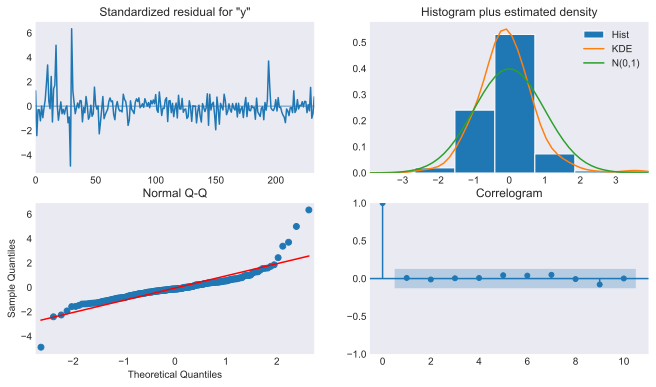

In [59]:
sarima_model = SARIMAX(ttrain['y'], order = (1,1,2), seasonal_order=(1,0,1,12), simple_differencing=False)

sarima_fit = sarima_model.fit(disp = False)

sarima_fit.plot_diagnostics(figsize = (11,6));

The residuals seem close enought to white noise, though there are some outliers. Lets check this statement quantitatively with and ljung-box test

In [60]:
resids = sarima_fit.resid

df_ljungbox = acorr_ljungbox(resids, lags=np.arange(1,10,1))

df_ljungbox

,lb_stat,lb_pvalue
1,0.144695,0.703657
2,0.549945,0.759593
3,0.554108,0.906853
4,0.561260,0.967270
5,0.648589,0.985671
6,0.648589,0.995534
7,0.696754,0.998361
8,0.698518,0.999530
9,0.706893,0.999867


All lagged residuals have p-values larger than 0.05 therefore we can not reject the null hypothesis: Residuals are white noise!

In [86]:
# get predictions using the start and end index of the test set

sarima_test_tpreds = sarima_fit.get_prediction(234,245).predicted_mean

# lets also get the confidence interval
conf_int_testdf = sarima_fit.get_prediction(234,245).conf_int(alpha = 0.05)

# inverse box-cox 
sarima_test_preds = inverse_boxcox(sarima_test_tpreds, lamb)
sarima_conf_int = inverse_boxcox(conf_int_testdf, lamb)

# add them to the test df where we collect all results and actual values

test['yhat_sarima'] = sarima_test_preds.values

test[['yhat_sarima_l','yhat_sarima_u']] = sarima_conf_int.values


In [88]:
# MAE of best SARIMA model 

mae_sarima = mean_absolute_error(test['y'], test['yhat_sarima'])

print(f"Test MAE of SARIMA: {mae_sarima:.3f}")

Test MAE of SARIMA: 1.983


We can see that SARIMA performs slightly worse than Naive Seasonal and could not beat Prophet for this data. 

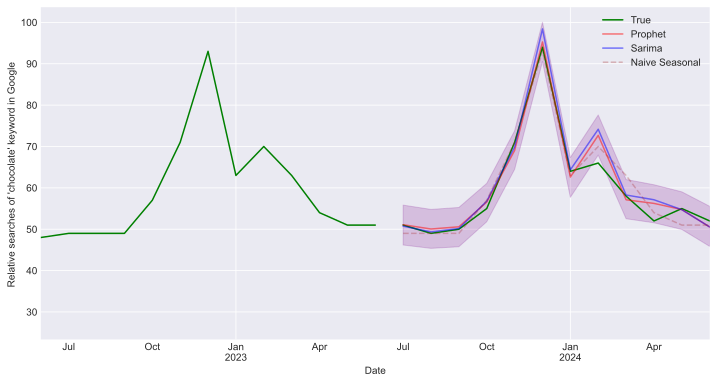

In [91]:
# Visualize the forecasts

train.index = train['ds']
test.index= test['ds']

fig, axes = plt.subplots(figsize = (12,6))

train['y'].plot(ax = axes, color = 'green', label = '')
test['y'].plot(ax = axes, color = 'green', label = 'True')
test['yhat'].plot(ax = axes, color = 'red', alpha = 0.5, label = 'Prophet')
test['yhat_sarima'].plot(ax = axes, color = 'blue', alpha = 0.5, label = 'Sarima')

test['naive_seasonal'].plot(ax = axes, color = 'brown', ls = '--', alpha = 0.3, label = 'Naive Seasonal')


axes.fill_between(x = test.index, y1 = test['yhat_lower'], y2 = test['yhat_upper'], color = 'red', alpha = 0.1)
axes.fill_between(x = test.index, y1 = test['yhat_lower'], y2 = test['yhat_upper'], color = 'blue', alpha = 0.1)


axes.set_xlim(train.index[-13],'2024-06-30')
axes.set_xlabel('Date')
axes.set_ylabel("Relative searches of 'chocolate' keyword in Google ")
axes.legend()

axes.grid()
